In [1]:
import pandas as pd
import numpy as np
from dataset_functions import *

In [2]:
df, target = get_dataset()
df, target = teamstats_teamheros_transform(df,target)

Features:  Index(['match_id_hash', 'game_time', 'game_mode', 'lobby_type',
       'objectives_len', 'chat_len', 'r1_hero_id', 'r1_kills', 'r1_deaths',
       'r1_assists',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=246) 

Target Columns:  Index(['match_id_hash', 'game_time', 'radiant_win', 'duration',
       'time_remaining', 'next_roshan_team'],
      dtype='object') 

Filtering Df:  (game_mode == 2 or game_mode == 22) and game_time > 0 

Dropped:  ['lobby_type', 'chat_len', 'game_mode'] 

Dataframe Shape:  (32153, 243) 

Hero Id Labels: ['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id'] 

Numbers of Heros:  115 



c:\Users\panal\VSCode\ML-Project\code\dataset_functions.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"d_{hero_id}"] = (
c:\Users\panal\VSCode\ML-Project\code\dataset_functions.py:164: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"r_{hero_id}"] = (
c:\Users\panal\VSCode\ML-Project\code\dataset_functions.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

Dataframe Shape: (32153, 463) 

NaN Count:  0 

Single Hero Labels: ['r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed', 'r2_kills', 'r2_deaths', 'r2_assists', 'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health', 'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns', 'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups', 'r2_firstblood_claimed', 'r2_teamfight_participation', 'r2_towers_killed', 'r2_roshans_killed', 'r2_obs_placed', 'r2_sen_placed', 'r3_kills', 'r3_deaths', 'r3_assists', 'r3_denies', 'r3_gold', 'r3_lh', 'r3_xp', 'r3_health', 'r3_max_health', 'r3_max_mana', 'r3_level', 'r3_x', 'r3_y', 'r3_stuns', 'r3_creeps_stacked', 'r3_camps_stacked', 'r3_rune_pic

In [3]:
win = target["radiant_win"].astype(int)
df = drop_heros_labels(df)

Hero Id Labels: [] 

Dropped Dataframe Shape: (32153, 64)


In [4]:
from sklearn.model_selection import train_test_split

np.random.seed(seed=10)

X_train,X_test,Y_train,Y_test = train_test_split(df,win,test_size=0.2)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold

params = {
    'n_estimators': [250,300],
    'criterion': ['entropy','gini','log_loss'],
}

feature_selector = GridSearchCV(estimator=RandomForestClassifier(),param_grid=params,scoring="roc_auc",cv=StratifiedKFold(n_splits=5,shuffle=True))

feature_selector.fit(X_train,Y_train)

c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\machine-learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'n_estimators': [250, 300]},
             scoring='roc_auc')

In [33]:
print(feature_selector.best_params_)
feature_selector = RandomForestClassifier(**feature_selector.best_params_)
feature_selector.fit(X_train,Y_train)

{'criterion': 'entropy', 'n_estimators': 250}


RandomForestClassifier(criterion='entropy', n_estimators=250)

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score

Y_pred = feature_selector.predict(X_test)

acc = accuracy_score(Y_test,Y_pred)
auc = roc_auc_score(Y_test,Y_pred)

print("Accouracy ",acc)
print("Auc",auc)

feature_importance = {
    name: value 
    for name,value in zip(feature_selector.feature_names_in_,feature_selector.feature_importances_)
}

feature_importance = dict(reversed(sorted(feature_importance.items(), key=lambda item: item[1])))
feature_names = list(feature_importance.keys())
print("Most Important:\n", feature_names[:10])
print("Least Important:\n", feature_names[-10:])


Accouracy  0.7188617633338517
Auc 0.7161459757237749
Most Important:
 ['d_gold', 'r_gold', 'd_health', 'd_kills', 'r2_y', 'd_deaths', 'r_kills', 'r_deaths', 'r_health', 'r_denies']
Least Important:
 ['d_sen_placed', 'r_obs_placed', 'r_creeps_stacked', 'objectives_len', 'd_camps_stacked', 'r_camps_stacked', 'd_firstblood_claimed', 'r_firstblood_claimed', 'r_roshans_killed', 'd_roshans_killed']


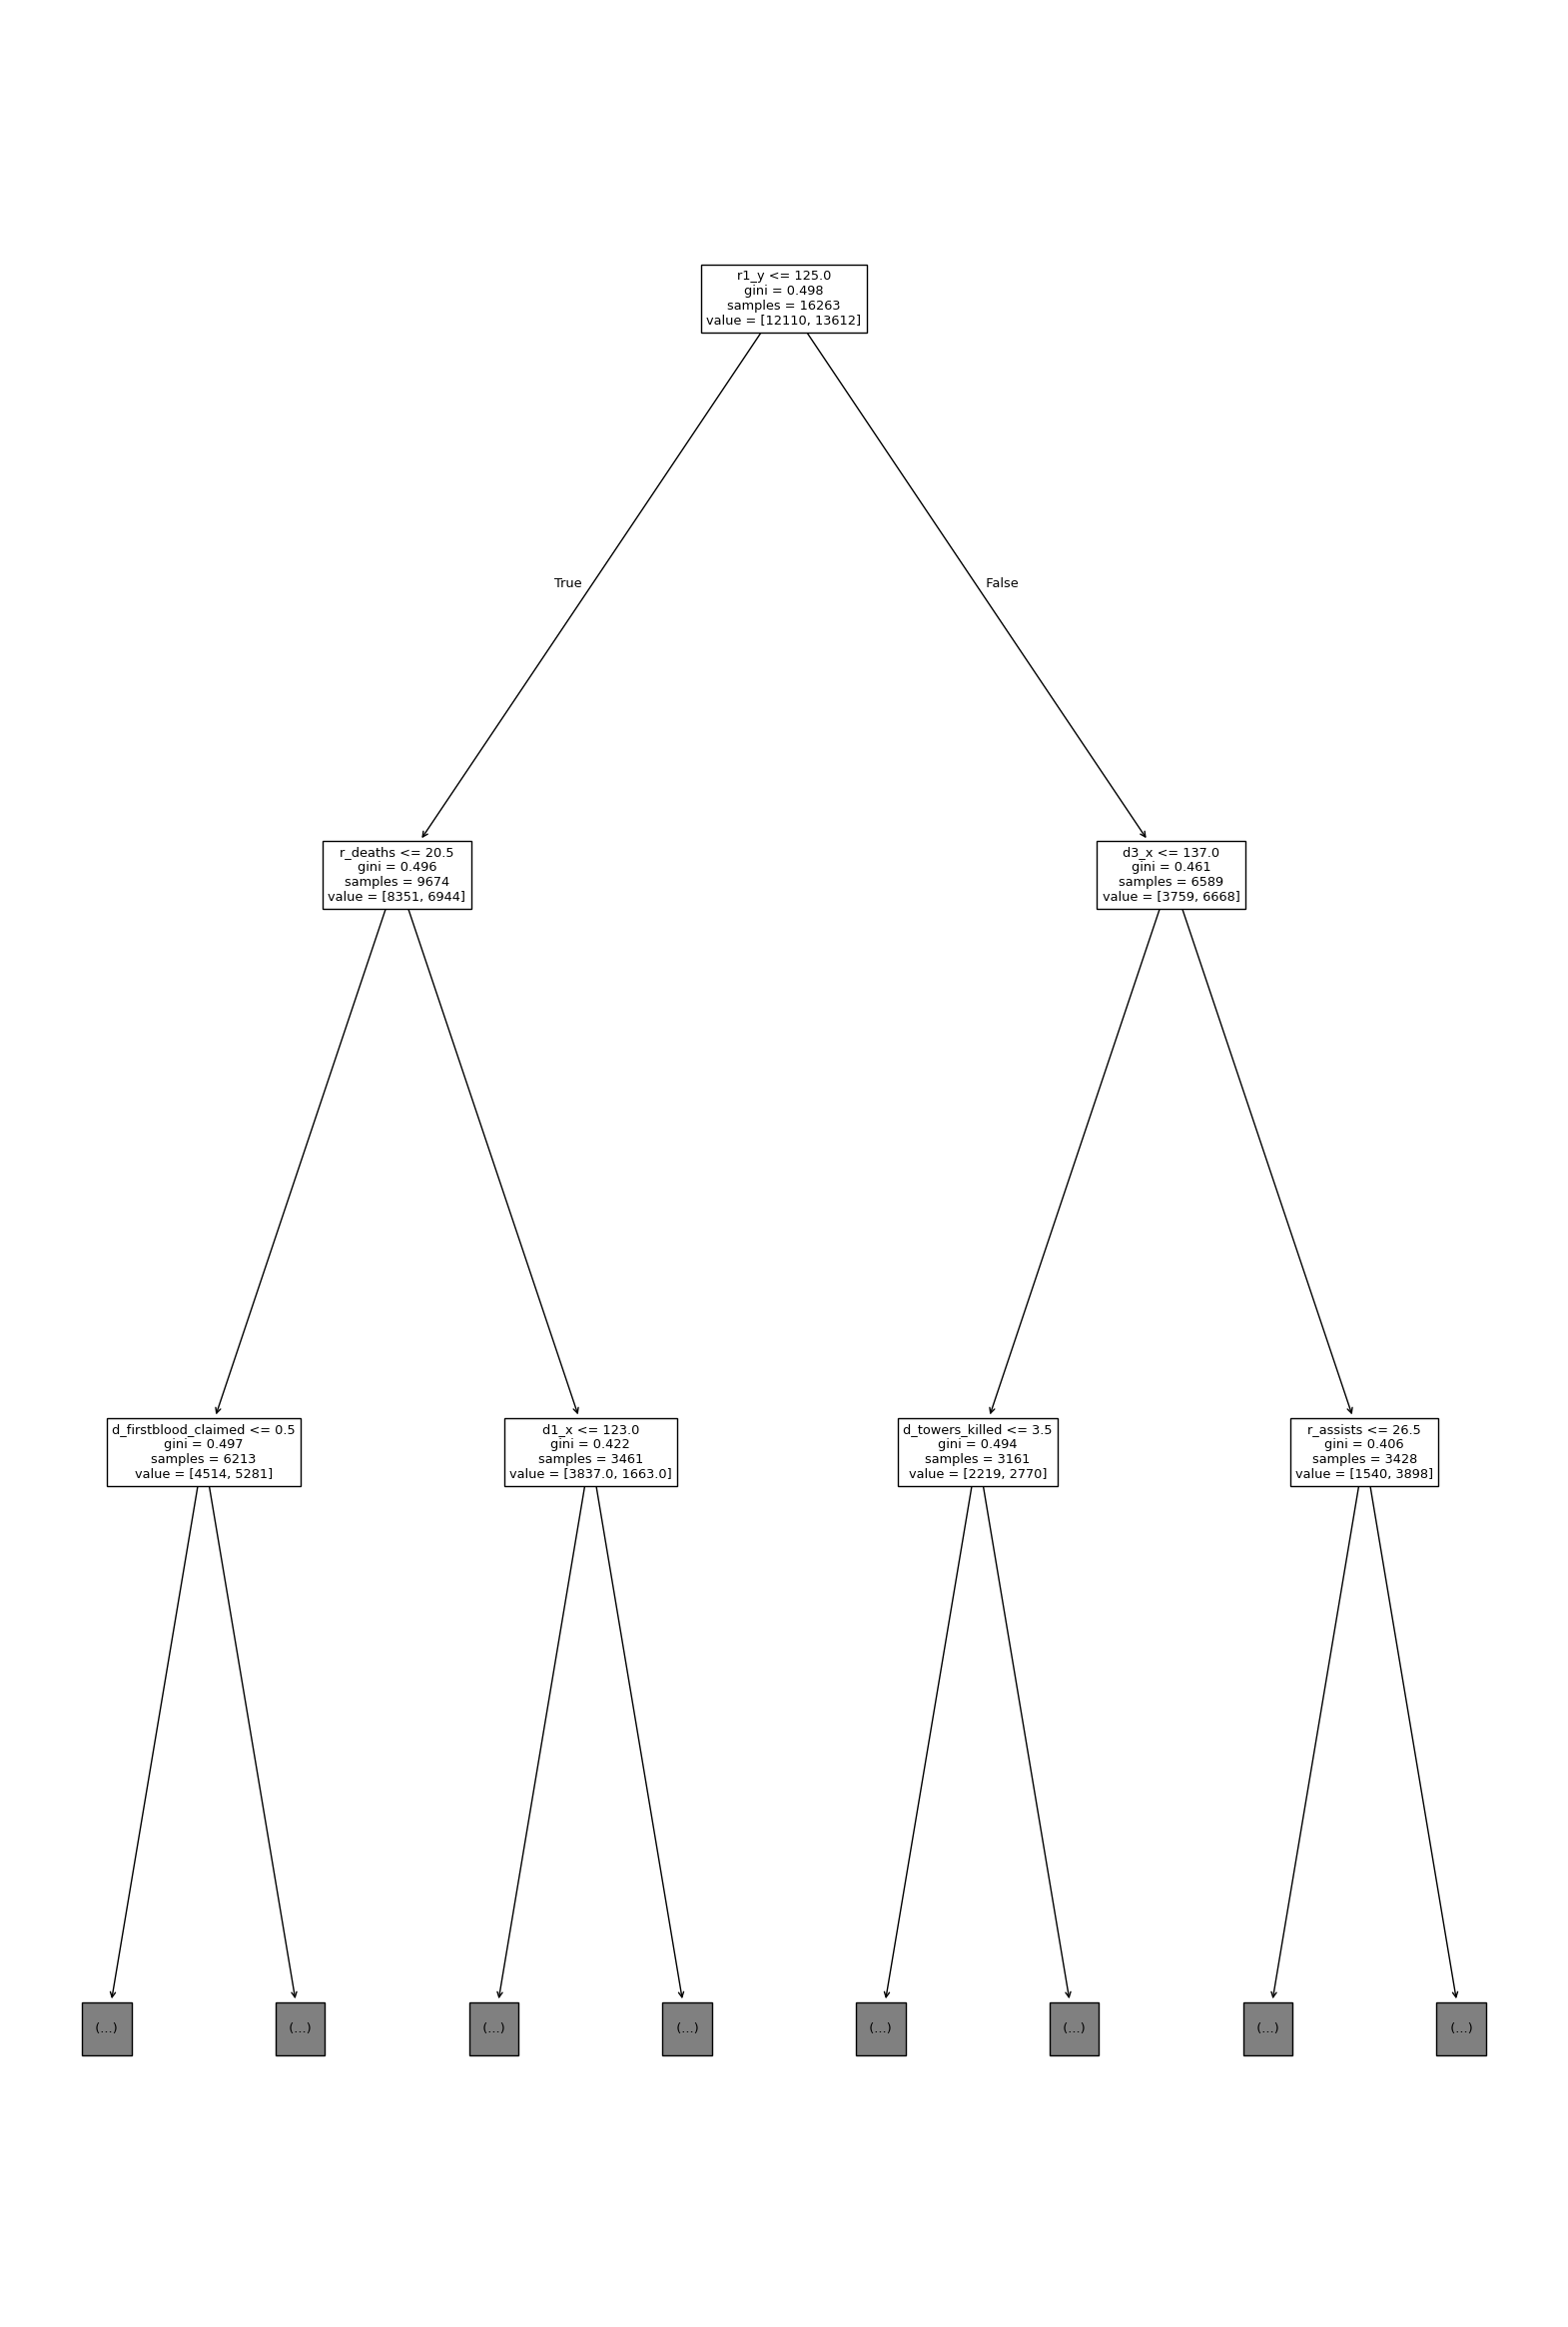

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree = feature_selector.estimators_[1]

plt.figure(figsize=(20,30))
plot_tree(tree,max_depth=2,feature_names=df.columns)
plt.show()